This notebook filters for questions from the initial training set of Quora questions from Kaggle to retain questions wherein >20% of the words in the questions are considered to be [biomedical terms](https://github.com/glutanimate/wordlist-medicalterms-en).


In [43]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jlzhou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
# download Kaggle training q's 
!wget https://www.kaggle.com/c/quora-insincere-questions-classification/download/train.csv

--2018-11-30 13:28:40--  https://www.kaggle.com/c/quora-insincere-questions-classification/download/train.csv
Resolving www.kaggle.com (www.kaggle.com)... 23.96.207.25
Connecting to www.kaggle.com (www.kaggle.com)|23.96.207.25|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /account/login?ReturnUrl=%2fc%2fquora-insincere-questions-classification%2fdownload%2ftrain.csv [following]
--2018-11-30 13:28:40--  https://www.kaggle.com/account/login?ReturnUrl=%2fc%2fquora-insincere-questions-classification%2fdownload%2ftrain.csv
Reusing existing connection to www.kaggle.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 6813 (6.7K) [text/html]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]   6.65K  --.-KB/s    in 0s      

2018-11-30 13:28:41 (36.5 MB/s) - ‘train.csv.1’ saved [6813/6813]



In [29]:
# load kaggle training q's (can load other sets of q's in this format as well)
quora_train = pd.read_csv('/Users/jlzhou/Documents/med277/train.csv')

# load medical terms
med_glossary = open('/Users/jlzhou/Documents/med277/wordlist-medicalterms-en/wordlist.txt').read().splitlines()
# convert glossary to set for faster lookups (?)
med_set = set(med_glossary)

In [40]:
# check how many stop words are in medical glossary
print(len(med_set&stop))

23


In [45]:
'''function for filtering questions
stop words not removed because they have negligible effect on filtering quality'''
def filter_questions(df):
    # get set of words in each question ("bag of words")
    df['bow'] = df.question_text.apply(lambda x: set([s.translate(str.maketrans('','',string.punctuation)) for s in x.split()]))
    
    # test which questions contain medical terms
    ix_to_keep = []
    for ix,row in df.iterrows():
        if len(row.bow & med_set) > 0.2*len(row.bow):
            ix_to_keep.append(ix)
    
    # subset df
    med_df = df.iloc[ix_to_keep,:]
    return med_df

In [46]:
quora_train_med = filter_questions(quora_train)
quora_train_med.head()

,qid,question_text,target,bow
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"{dog, Do, encourage, not, have, people, how, w..."
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"{velocity, geometry, affect, Why, space, does,..."
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"{did, von, hemispheres, used, How, the, Magdeb..."
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0,"{off, are, wash, Is, everywhere, it, wipe, I, ..."
10,000075f67dd595c3deb5,What can you say about feminism?,0,"{can, about, say, feminism, you, What}"


In [47]:
# write to file
quora_train_med.to_csv('/Users/jlzhou/Documents/med277/quora_train_med.csv', index=False)

Let's take a look at one of the questions remaining after filtering:

In [48]:
quora_train_med.iloc[0,:].question_text

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

Which of the words in this sentence are from the set of medical terms?

In [49]:
quora_train_med.iloc[0,:].bow&med_set

{'and', 'dog', 'not', 'shop'}

In [50]:
print('%d questions in initial set of questions' % quora_train.shape[0])
print('%d questions in filtered set of questions' % quora_train_med.shape[0])
print('%d insincere (target) questions in initial set' % sum(quora_train.target))
print('%d insincere (target) questions in filtered set' % sum(quora_train_med.target))

1306122 questions in initial set of questions
688560 questions in filtered set of questions
80810 insincere (target) questions in initial set
37365 insincere (target) questions in filtered set


Percent of insincere entries 5.427 %


,qid,question_text,target,bow
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1,"{largest, dictatorship, States, the, become, i..."
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1,"{Dark, Which, are, babies, parents, their, mor..."
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1,"{dont, Republican, for, mandatory, blacks, sup..."
127,0005de07b07a17046e27,How do I marry an American woman for a Green C...,1,"{marry, for, woman, Green, How, American, char..."
167,00075f7061837807c69f,In what manner has Republican backing of 'stat...,1,"{of, make, the, In, to, have, been, ways, stat..."


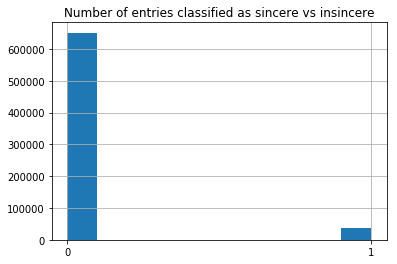

In [51]:
fig,ax = plt.subplots(1,1)
quora_train_med.hist(column = 'target', ax = ax)
ax.set_title('Number of entries classified as sincere vs insincere')
ax.set_xticks([0,1])
print('Percent of insincere entries %.3f %%'%(100*(sum(quora_train_med['target'])/len(quora_train_med))))

quora_train_med[quora_train_med['target']==1].head()

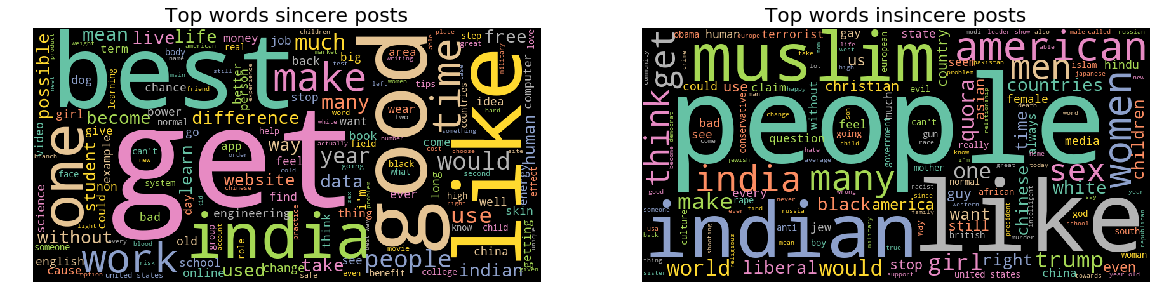

In [52]:
n_posts = 1000
q_S = ' '.join(quora_train_med[quora_train_med['target'] == 0]['question_text'].str.lower().values[:n_posts])
q_I = ' '.join(quora_train_med[quora_train_med['target'] == 1]['question_text'].str.lower().values[:n_posts])

wordcloud_S = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Set2').generate(q_S)
wordcloud_I = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Set2').generate(q_I)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
ax[0].imshow(wordcloud_S)
ax[0].set_title('Top words sincere posts',fontsize = 20)
ax[0].axis("off")

ax[1].imshow(wordcloud_I)
ax[1].set_title('Top words insincere posts',fontsize = 20)
ax[1].axis("off")

plt.show()